# Big mart Sales prediction

## Objetivo Principal
Desarrollar modelos predictivos precisos para estimar las ventas de productos alimenticios en tiendas utilizando el conjunto de datos "Big Mart Sales Prediction".
## Objetivos Secundarios
1. Identificar las características clave de los productos que afectan las ventas, como el peso del artículo, el contenido de grasa, el tipo de artículo y el precio MRP (Maximum Retail Price).
2. Analizar la influencia de las características del punto de venta, como el tamaño del establecimiento, la ubicación y el tipo de tienda, en las ventas de productos.
3. Proporcionar a los minoristas una comprensión detallada de los factores que impulsan las ventas y sugerir estrategias para mejorar el rendimiento de ventas.
4. Documentar el proceso de desarrollo del modelo y compartir el código en un repositorio público en GitHub para su revisión, colaboración y uso como referencia para futuras investigaciones y análisis relacionados con el proyecto.



# Carga y pre-work

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

import plotly.express as px
import plotly.graph_objects as go

In [3]:
import os
print(os.getcwd())

/content


In [4]:
sp_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_para_Panda_CienciaDeDatos/sales_predictions.csv')
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# Análisis Exploratorio de Datos

Aqui veo que tengo dos columnas con valores faltantes:
* Item_Weight
* Outlet_Size

In [5]:
sp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


Observaciones:

Item_Visibility:
* La visibilidad de los productos varía considerablemente, con un valor medio de aproximadamente 0.066 y un rango intercuartil (IQR) de 0.068.
* Se observan valores atípicos en la visibilidad de los productos, ya que el valor máximo es mucho mayor que el tercer cuartil (Q3 + 1.5 * IQR). Esto sugiere la presencia de productos con una visibilidad inusualmente alta (superior a 0.16)
* Además, se registran valores de visibilidad igual a 0, lo que indica que hay productos que no son visibles para los clientes en las tiendas, lo que podría afectar negativamente sus ventas.


Item_Outlet_Sales:
* Las ventas de los productos en las tiendas varían ampliamente, con un valor medio de aproximadamente 2181.29 y un rango intercuartil (IQR) de 2267.05.
* Se observan valores atípicos en las ventas de productos, ya que el valor máximo es significativamente mayor que el tercer cuartil (Q3 + 1.5 * IQR). Esto sugiere la presencia de productos con ventas excepcionalmente altas (superior a 5,061.74).
* La disparidad en las ventas puede estar relacionada con la visibilidad de los productos, ya que los productos con una visibilidad baja pueden tener ventas más bajas debido a su menor exposición a los clientes.


## Analizando Columna Item_Weight

In [6]:
sp_df_wna = sp_df[sp_df['Item_Weight'].isna()]
sp_df_wna

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
...,...,...,...,...,...,...,...,...,...,...,...,...
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8488,NCN14,NaN,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120
8490,FDU44,NaN,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656


Tengo 1463 registros de productos, sin peso.

In [7]:
sp_df_wna['Item_Identifier'].value_counts().sort_index()

Item_Identifier
DRA24    2
DRA59    2
DRB01    1
DRB25    1
DRB48    1
        ..
NCZ17    1
NCZ18    1
NCZ30    1
NCZ53    1
NCZ54    2
Name: count, Length: 1142, dtype: int64

In [8]:
sp_df_w = sp_df[sp_df['Item_Weight'].notna()]
sp_df_w

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


Tengo 7060 registros de productos con peso, me puede servir asociar el Item_identifier a un peso único y asi completar los valores nulos de la columna Item_Weight.

In [9]:
sp_df_w['Item_Identifier'].value_counts().sort_index()

Item_Identifier
DRA12    6
DRA24    5
DRA59    6
DRB01    2
DRB13    5
        ..
NCZ30    6
NCZ41    5
NCZ42    5
NCZ53    4
NCZ54    5
Name: count, Length: 1555, dtype: int64

Reviso cuantos codigos de producto tengo, hay 1555 valores unicos de 1559 que tiene la base principal, eso quiere decir que habra 4 sin poder reemplazar con la relacion codigo producto - peso.

In [10]:
base_IDproducto_peso = sp_df_w[['Item_Identifier', 'Item_Weight']].drop_duplicates()
base_IDproducto_peso.sort_index()

,Item_Identifier,Item_Weight
0,FDA15,9.300
1,DRC01,5.920
2,FDN15,17.500
3,FDX07,19.200
4,NCD19,8.930
...,...,...
7298,NCW05,20.250
7373,FDS09,8.895
7421,FDU43,19.350
7944,FDO49,10.600


In [11]:
sp_df[['Item_Identifier', 'Item_Weight']].drop_duplicates()

,Item_Identifier,Item_Weight
0,FDA15,9.30
1,DRC01,5.92
2,FDN15,17.50
3,FDX07,19.20
4,NCD19,8.93
...,...,...
8471,NCT53,5.40
8472,NCS41,NaN
8480,FDQ58,NaN
8487,DRG13,NaN


In [12]:
base_IDproducto_peso['Item_Identifier'].duplicated().sum()

0

Ahora creo un diccionario con los codigos de producto y peso, esto me sirve para reemplazar los valores faltantes.

In [13]:
dic_peso = base_IDproducto_peso.set_index('Item_Identifier')['Item_Weight'].to_dict()
dic_peso

{'FDA15': 9.3,
 'DRC01': 5.92,
 'FDN15': 17.5,
 'FDX07': 19.2,
 'NCD19': 8.93,
 'FDP36': 10.395,
 'FDO10': 13.65,
 'FDH17': 16.2,
 'FDU28': 19.2,
 'FDY07': 11.8,
 'FDA03': 18.5,
 'FDX32': 15.1,
 'FDS46': 17.6,
 'FDF32': 16.35,
 'FDP49': 9.0,
 'NCB42': 11.8,
 'FDU02': 13.35,
 'FDN22': 18.85,
 'NCB30': 14.6,
 'FDR28': 13.85,
 'NCD06': 13.0,
 'FDV10': 7.645,
 'DRJ59': 11.65,
 'FDE51': 5.925,
 'FDV38': 19.25,
 'NCS17': 18.6,
 'FDP33': 18.7,
 'FDO23': 17.85,
 'DRH01': 17.5,
 'NCX29': 10.0,
 'DRZ11': 8.85,
 'FDK43': 9.8,
 'FDA46': 13.6,
 'FDC02': 21.35,
 'FDL50': 12.15,
 'FDM39': 6.42,
 'NCP05': 19.6,
 'FDV49': 10.0,
 'FDL12': 15.85,
 'NCL17': 7.39,
 'FDM40': 10.195,
 'FDR13': 9.895,
 'FDA43': 10.895,
 'NCP18': 12.15,
 'FDK21': 7.905,
 'NCX54': 9.195,
 'DRK35': 8.365,
 'FDY21': 15.1,
 'FDM20': 10.0,
 'FDV27': 7.97,
 'FDC46': 17.7,
 'FDH19': 19.35,
 'FDZ03': 13.65,
 'DRH37': 17.6,
 'NCI17': 8.645,
 'FDJ58': 15.6,
 'FDH35': 18.25,
 'FDG02': 7.855,
 'NCZ18': 7.825,
 'FDC29': 8.39,
 'FDQ10': 12.

In [14]:
len(dic_peso)

1555

In [15]:
sp_df.loc[sp_df['Item_Weight'].isna(), 'Item_Weight'] = sp_df.loc[sp_df['Item_Weight'].isna(), 'Item_Identifier'].map(dic_peso)

Compruebo para ver los 4 productos que no tienen peso:

In [16]:
sp_df[sp_df['Item_Weight'].isna()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


Veo que los productos tienen un correlativo, es posible que ordenando el codigo de producto se pueda ver alguna relacion con el peso.

In [17]:
filtro1 = sp_df[sp_df['Item_Identifier'].str.startswith('FDN')].sort_values(by='Item_Identifier')
filtro1[['Item_Identifier',	'Item_Weight']].drop_duplicates()

,Item_Identifier,Item_Weight
3683,FDN01,8.895
852,FDN02,16.500
6912,FDN03,9.800
2729,FDN04,11.800
3945,FDN08,7.720
1953,FDN09,14.150
2666,FDN10,11.500
3086,FDN12,15.600
3767,FDN13,18.600
4817,FDN15,17.500


Como no hay una relacion veamos si ha nivel de tienda y tipo de producto, hay alguna relacion en cuanto al peso.

In [18]:
filtro2 = sp_df[(sp_df['Item_Identifier'].str.startswith('FDN')) & (sp_df['Item_Type']=='Frozen Foods') & (sp_df['Outlet_Identifier']=='OUT027')]
filtro2[['Item_Identifier',	'Item_Weight']].drop_duplicates()

,Item_Identifier,Item_Weight
927,FDN52,NaN
1142,FDN04,11.8


Tiene muy pocos valores para inferir, por tanto vamos a usar la media agrupada por tipo de producto y codigo para completar tanto este valor como el resto de los productos.

In [19]:
FDN_df = sp_df[(sp_df['Item_Identifier'].str.startswith('FDN')) & (sp_df['Item_Type']=='Frozen Foods')]
media_FDN = FDN_df['Item_Weight'].mean()
print('El valor para FDN52 será de', round(media_FDN,2))

El valor para FDN52 será de 9.45


In [20]:
FDK_df = sp_df[(sp_df['Item_Identifier'].str.startswith('FDK')) & (sp_df['Item_Type']=='Snack Foods')]
media_FDK = FDK_df['Item_Weight'].mean()
print('El valor para FDK57 será de', round(media_FDK,2))

El valor para FDK57 será de 11.55


In [21]:
FDE_df = sp_df[(sp_df['Item_Identifier'].str.startswith('FDE')) & (sp_df['Item_Type']=='Dairy')]
media_FDE = FDE_df['Item_Weight'].mean()
print('El valor para FDE52 será de', round(media_FDE,2))

El valor para FDE52 será de 9.66


In [22]:
FDQ_df = sp_df[(sp_df['Item_Identifier'].str.startswith('FDQ')) & (sp_df['Item_Type']=='Baking Goods')]
media_FDQ = FDQ_df['Item_Weight'].mean()
print('El valor para FDQ60 será de', round(media_FDQ,2))

El valor para FDQ60 será de 12.28


In [23]:
dic_peso_2 = { 'FDN52' : 9.45,
               'FDK57' : 11.55,
               'FDE52' : 9.66,
               'FDQ60' : 12.28 }

sp_df.loc[sp_df['Item_Weight'].isna(), 'Item_Weight'] = sp_df.loc[sp_df['Item_Weight'].isna(), 'Item_Identifier'].map(dic_peso_2)

In [24]:
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Ya tengo todos los valores reemplazados. Convierto la columna Item_Weight a float.

In [25]:
sp_df['Item_Weight'].astype('float')

0        9.300
1        5.920
2       17.500
3       19.200
4        8.930
         ...  
8518     6.865
8519     8.380
8520    10.600
8521     7.210
8522    14.800
Name: Item_Weight, Length: 8523, dtype: float64

In [26]:
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Analizando Columna Outlet_Size

In [27]:
sp_df_sna = sp_df[sp_df['Outlet_Size'].isna()]
sp_df_sna

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
25,NCD06,13.000,Low Fat,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344
...,...,...,...,...,...,...,...,...,...,...,...,...
8502,NCH43,8.420,Low Fat,0.070712,Household,216.4192,OUT045,2002,NaN,Tier 2,Supermarket Type1,3020.0688
8508,FDW31,11.350,Regular,0.043246,Fruits and Vegetables,199.4742,OUT045,2002,NaN,Tier 2,Supermarket Type1,2587.9646
8509,FDG45,8.100,Low Fat,0.214306,Fruits and Vegetables,213.9902,OUT010,1998,NaN,Tier 3,Grocery Store,424.7804
8514,FDA01,15.000,Regular,0.054489,Canned,57.5904,OUT045,2002,NaN,Tier 2,Supermarket Type1,468.7232


Tengo 240 registros de tamaño, con valores nulos. Revisemos cuales son los Outlet que no tienen tamaño y si tenemos alguna otra data de los mismos.

In [28]:
sp_df_sna.groupby('Outlet_Identifier')['Outlet_Size'].unique()

Outlet_Identifier
OUT010    [nan]
OUT017    [nan]
OUT045    [nan]
Name: Outlet_Size, dtype: object

In [29]:
sp_df.groupby('Outlet_Identifier')['Outlet_Size'].unique()

Outlet_Identifier
OUT010       [nan]
OUT013      [High]
OUT017       [nan]
OUT018    [Medium]
OUT019     [Small]
OUT027    [Medium]
OUT035     [Small]
OUT045       [nan]
OUT046     [Small]
OUT049    [Medium]
Name: Outlet_Size, dtype: object

No hay información para esos outlets en otros registros.

In [30]:
sp_df.groupby(['Outlet_Identifier','Outlet_Size'])['Item_Outlet_Sales'].sum()/1000

Outlet_Identifier  Outlet_Size
OUT013             High           2142.663578
OUT018             Medium         1851.822830
OUT019             Small           179.694094
OUT027             Medium         3453.926051
OUT035             Small          2268.122935
OUT046             Small          2118.395168
OUT049             Medium         2183.969810
Name: Item_Outlet_Sales, dtype: float64

No hay un relacion entre el Size y las ventas totales por establecimiento.

In [31]:
sp_df.groupby('Outlet_Location_Type')['Outlet_Size'].unique()

Outlet_Location_Type
Tier 1        [Medium, Small]
Tier 2           [nan, Small]
Tier 3    [Medium, nan, High]
Name: Outlet_Size, dtype: object

El tipo de locación también es variado.


In [32]:
sp_df.groupby('Outlet_Type')['Outlet_Size'].unique()

Outlet_Type
Grocery Store                      [nan, Small]
Supermarket Type1    [Medium, High, nan, Small]
Supermarket Type2                      [Medium]
Supermarket Type3                      [Medium]
Name: Outlet_Size, dtype: object

Podemos determinar que una Grocery Store siempre sera Small, ademas es la moda dentro de esa categoría, por tanto consideraremos:
* OUT010 igual a Small.

In [33]:
grocery_small = sp_df[sp_df['Outlet_Identifier'] == 'OUT010']
grocery_small['Outlet_Size'].fillna('Small', inplace=True)
sp_df.update(grocery_small)
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6668 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


<ipython-input-33-4436b57e6cc8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grocery_small['Outlet_Size'].fillna('Small', inplace=True)


Revisemos los otros 2 Outlets:
* OUT017
* OUT045

In [34]:
sp_df.groupby(['Outlet_Location_Type','Outlet_Type',])['Outlet_Size'].unique()

Outlet_Location_Type  Outlet_Type      
Tier 1                Grocery Store                [Small]
                      Supermarket Type1    [Medium, Small]
Tier 2                Supermarket Type1       [nan, Small]
Tier 3                Grocery Store                [Small]
                      Supermarket Type1             [High]
                      Supermarket Type2           [Medium]
                      Supermarket Type3           [Medium]
Name: Outlet_Size, dtype: object

In [35]:
sp_df.groupby(['Outlet_Identifier','Outlet_Size'])['Item_Identifier'].nunique()

Outlet_Identifier  Outlet_Size
OUT010             Small          555
OUT013             High           932
OUT018             Medium         928
OUT019             Small          528
OUT027             Medium         935
OUT035             Small          930
OUT046             Small          930
OUT049             Medium         930
Name: Item_Identifier, dtype: int64

Agrupando tipo de locacion y tipo de Outlet, es probale que el valor faltante para Supermarket Type1 sea Medium, pero para confirmar revisemos la moda.

Por otro lado no hay relación entre el Outlet Size y la cantidad de productos vendidos.


In [36]:
filtro_sup1 = sp_df[sp_df['Outlet_Type'] == 'Supermarket Type1']
filtro_sup1['Outlet_Size'].value_counts()

Outlet_Size
Small     1860
High       932
Medium     930
Name: count, dtype: int64

In [37]:
filtro_sup1.groupby(['Outlet_Location_Type'])['Outlet_Identifier'].unique()

Outlet_Location_Type
Tier 1            [OUT049, OUT046]
Tier 2    [OUT045, OUT017, OUT035]
Tier 3                    [OUT013]
Name: Outlet_Identifier, dtype: object

Revisando el valor que mas repite para Supermarket Type 1 es Small, además según muestra el Tier 2 para Supermarket Type, el outlet OUT035 es Small por tanto consideraremos:

* OUT045 igual a Small.
* OUT017 igual a Small.

In [38]:
filtro_OUT045 = sp_df[sp_df['Outlet_Identifier'] == 'OUT045']
filtro_OUT045['Outlet_Size'].fillna('Small', inplace=True)
sp_df.update(filtro_OUT045)
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                7597 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


<ipython-input-38-311d426b40c4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtro_OUT045['Outlet_Size'].fillna('Small', inplace=True)


In [39]:
filtro_OUT017 = sp_df[sp_df['Outlet_Identifier'] == 'OUT017']
filtro_OUT017['Outlet_Size'].fillna('Small', inplace=True)
sp_df.update(filtro_OUT017)
sp_df.info()

<ipython-input-39-3f020c2aacb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtro_OUT017['Outlet_Size'].fillna('Small', inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Analizando Item_Fat_Content  

In [40]:
sp_df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

In [41]:
sp_df['Item_Fat_Content'] = sp_df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})
sp_df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

# Resúmenes estadísticos, información agregada, u otras tendencias observables


In [42]:
sp_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.874416,0.066132,140.992782,1997.831867,2181.288914
std,4.645313,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.785000,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


En Item_Visibility hay al menos un producto con valor cero, veamos si tienen ventas.

In [43]:
filtro_visib_cero = sp_df[sp_df['Item_Visibility'] == 0]
filtro_visib_cero

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.0,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.0,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.0,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
10,FDY07,11.800,Low Fat,0.0,Fruits and Vegetables,45.5402,OUT049,1999,Medium,Tier 1,Supermarket Type1,1516.0266
32,FDP33,18.700,Low Fat,0.0,Snack Foods,256.6672,OUT018,2009,Medium,Tier 3,Supermarket Type2,3068.0064
...,...,...,...,...,...,...,...,...,...,...,...,...
8480,FDQ58,7.315,Low Fat,0.0,Snack Foods,154.5340,OUT019,1985,Small,Tier 1,Grocery Store,459.4020
8484,DRJ49,6.865,Low Fat,0.0,Soft Drinks,129.9652,OUT013,1987,High,Tier 3,Supermarket Type1,2324.9736
8486,FDR20,20.000,Regular,0.0,Fruits and Vegetables,46.4744,OUT010,1998,Small,Tier 3,Grocery Store,45.2744
8494,NCI54,15.200,Low Fat,0.0,Household,110.4912,OUT017,2007,Small,Tier 2,Supermarket Type1,1637.8680


Revisando vemos que corresponde a 526 registros de los cuales si tenemos ventas, y los registros provienen de dos tiendas OUT010 y OUT049. Podría entenderse que si bien los productos no son visibles los clientes los solicitan a pedido.

In [44]:
filtro_visib_cero.groupby(['Outlet_Identifier', 'Item_Type'])['Item_Outlet_Sales'].sum()

Outlet_Identifier  Item_Type            
OUT010             Breads                     585.2382
                   Canned                     188.4214
                   Frozen Foods               873.5296
                   Fruits and Vegetables     2557.3378
                   Hard Drinks                129.8310
                                               ...    
OUT049             Meat                      1896.1984
                   Others                    1120.5414
                   Snack Foods              12507.7188
                   Soft Drinks               4223.1694
                   Starchy Foods             4296.4074
Name: Item_Outlet_Sales, Length: 132, dtype: float64

In [45]:
sp_df.groupby(['Item_Identifier', 'Outlet_Identifier'])['Item_MRP'].mean().reset_index()

,Item_Identifier,Outlet_Identifier,Item_MRP
0,DRA12,OUT010,143.0154
1,DRA12,OUT013,142.3154
2,DRA12,OUT017,140.3154
3,DRA12,OUT018,142.0154
4,DRA12,OUT035,141.9154
...,...,...,...
8518,NCZ54,OUT019,160.9552
8519,NCZ54,OUT027,164.0552
8520,NCZ54,OUT045,162.4552
8521,NCZ54,OUT046,161.9552


Cada Outlet tiene el poder de modificar el precio de sus productos, sin embargo la variación significativa sólo es entre distintos tipos de productos, dentro de los mismos no es considerable.

In [46]:
sp_df.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].sum()/1000

Outlet_Location_Type
Tier 1    4482.059072
Tier 2    6472.313706
Tier 3    7636.752632
Name: Item_Outlet_Sales, dtype: float64

El grupo de tiendas que mas ventas ha realizado es el Tier 3.

In [47]:
outlets_tier3 = sp_df[sp_df['Outlet_Location_Type'] == 'Tier 3']
outlets_tier3.groupby('Outlet_Identifier')['Item_Outlet_Sales'].sum().sort_values(ascending=False)/1000

Outlet_Identifier
OUT027    3453.926051
OUT013    2142.663578
OUT018    1851.822830
OUT010     188.340172
Name: Item_Outlet_Sales, dtype: float64

Estas son los 4 outlets que realizaron más ventas.

In [48]:
outlets_tier1 = sp_df[sp_df['Outlet_Location_Type'] == 'Tier 1']
outlets_tier1.groupby('Outlet_Identifier')['Item_Outlet_Sales'].sum().sort_values()/1000

Outlet_Identifier
OUT019     179.694094
OUT046    2118.395168
OUT049    2183.969810
Name: Item_Outlet_Sales, dtype: float64

Estas son los 3 outlets que realizaron menos ventas.

In [49]:
sp_df['Cantidades_vendidas'] = sp_df['Item_Outlet_Sales'] / sp_df['Item_MRP']
Cantidades_vendidas_por_item = sp_df.groupby(['Item_Identifier', 'Item_Type'])['Cantidades_vendidas'].sum()
top_10_items = Cantidades_vendidas_por_item.sort_values(ascending=False).head(10)
top_10_items

Item_Identifier  Item_Type            
NCL31            Others                   183.840043
FDO19            Fruits and Vegetables    183.074268
FDW13            Canned                   177.901653
FDL34            Snack Foods              177.790164
FDJ21            Snack Foods              173.096500
NCK53            Health and Hygiene       172.117134
FDT55            Fruits and Vegetables    171.783009
NCB18            Household                167.735616
FDG38            Canned                   166.884902
FDA15            Dairy                    166.633479
Name: Cantidades_vendidas, dtype: float64

Estos son los 10 productos mas vendidos, y las categorias a la que pertenecen.



# Visualizaciones de datos para análisis exploratorio de datos y para análisis explicativo de datos.


## Visualizaciones de Analisis exploratorio de los datos (EDA)

In [50]:
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  Cantidades_vendidas        8523 non-null   float64
dtypes: float64(5), int64(1), object(7)
memory usage:

In [51]:
sp_df.nunique()

Item_Identifier              1559
Item_Weight                   419
Item_Fat_Content                2
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
Cantidades_vendidas          8177
dtype: int64

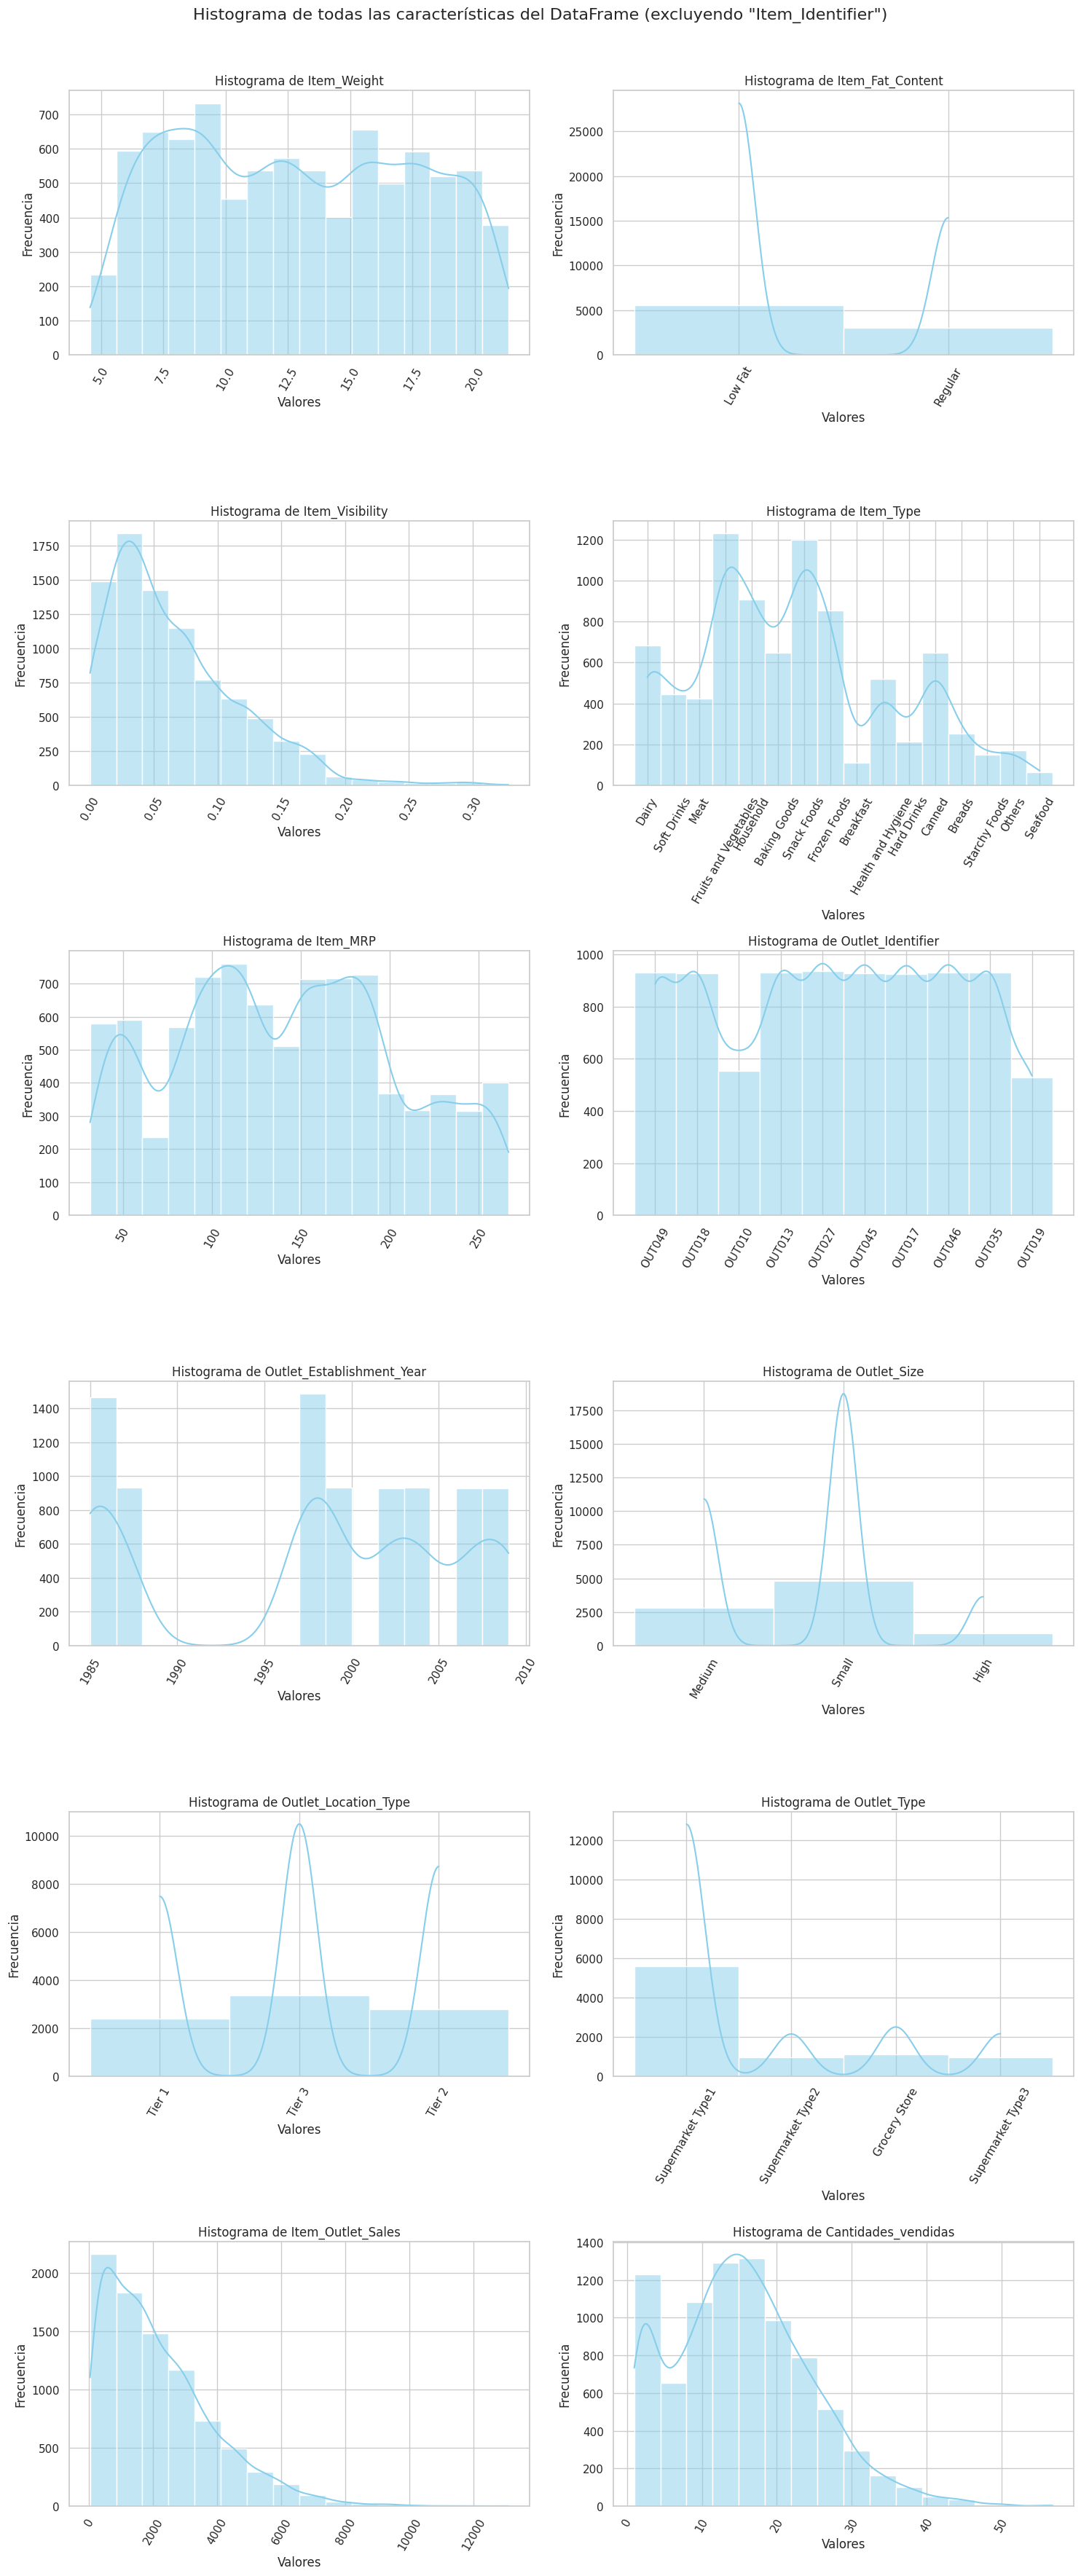

In [52]:
# @title  Histograma de todas las características

df_filtered = sp_df.drop(columns=["Item_Identifier"])

sns.set(style='whitegrid')

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 35))

for i, column in enumerate(df_filtered.columns):
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    sns.histplot(data=df_filtered, x=column, ax=ax, color='skyblue', kde=True, bins=16)
    ax.set_title(f'Histograma de {column}')
    ax.set_ylabel('Frecuencia')
    ax.set_xlabel('Valores')
    ax.tick_params(axis='x', rotation=60)

plt.suptitle('Histograma de todas las características del DataFrame (excluyendo "Item_Identifier")', fontsize=16, y=1.01)

plt.tight_layout()
plt.show()

df_filtered_2 'Item_Fat_Content' para poder ver su relacion con las ventas

In [53]:
df_filtered_2 = df_filtered.copy()
df_filtered_2['Item_Fat_Content'] = df_filtered_2['Item_Fat_Content'].replace({'Low Fat':0, 'Regular':1})

<ipython-input-54-d837ece63b8c>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Item_Fat_Content', y='Cantidades_vendidas', data=df_filtered, palette=palette, ax=ax[1])
<ipython-input-54-d837ece63b8c>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Item_Fat_Content', y='Item_MRP', data=df_filtered, palette=palette, ax=ax[2])


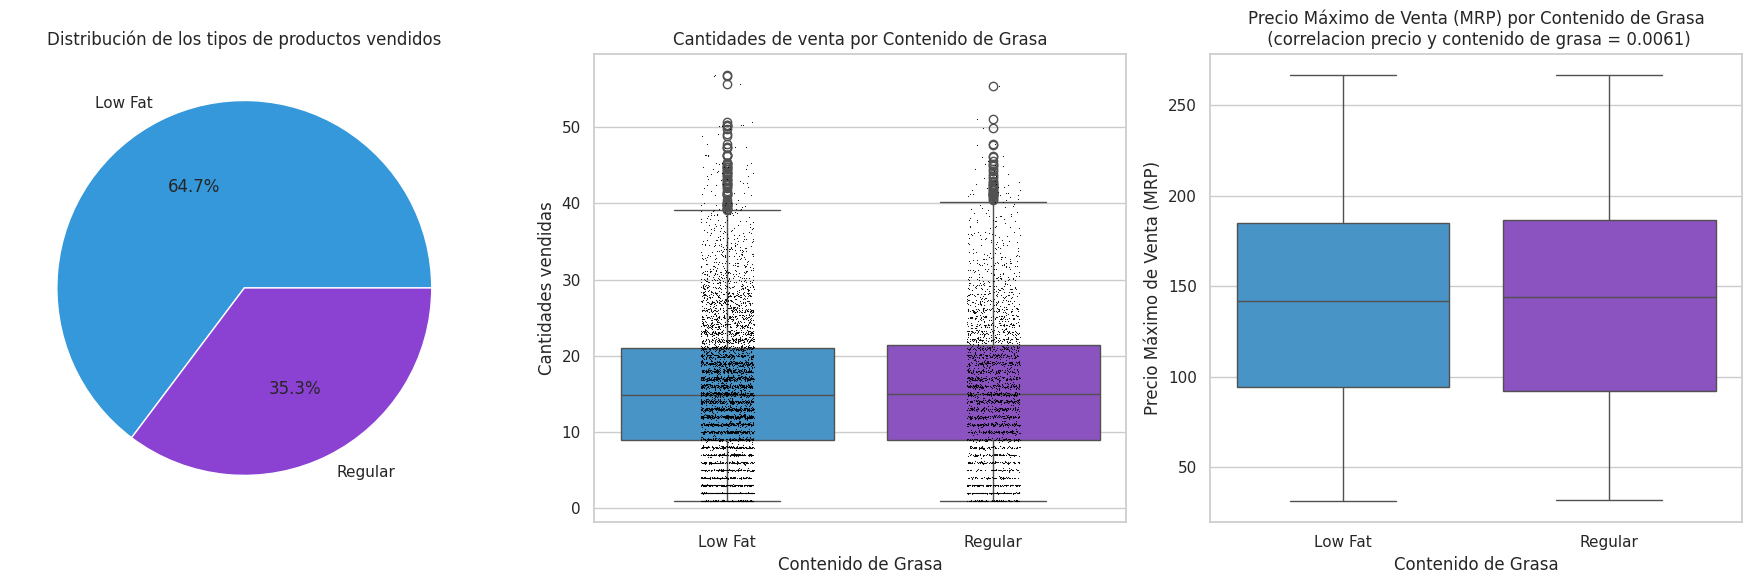

In [54]:
# @title  Distribución de productos según contenido de grasa y su relación con las Ventas y el MRP
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

palette = ["#3498db", "#8b41d2"]
correlacion_grasa = df_filtered_2['Item_Fat_Content'].corr(df_filtered_2['Item_MRP'])

fat_content_counts = df_filtered['Item_Fat_Content'].value_counts()
ax[0].pie(fat_content_counts, labels=fat_content_counts.index, colors=palette, autopct='%1.1f%%')
ax[0].set_title('Distribución de los tipos de productos vendidos')

sns.boxplot(x='Item_Fat_Content', y='Cantidades_vendidas', data=df_filtered, palette=palette, ax=ax[1])
sns.stripplot(x='Item_Fat_Content', y='Cantidades_vendidas', data=df_filtered, jitter=True, color='black', size=0.8, ax=ax[1])
ax[1].set_title('Cantidades de venta por Contenido de Grasa')
ax[1].set_xlabel('Contenido de Grasa')
ax[1].set_ylabel('Cantidades vendidas')

sns.boxplot(x='Item_Fat_Content', y='Item_MRP', data=df_filtered, palette=palette, ax=ax[2])
ax[2].set_title(f'Precio Máximo de Venta (MRP) por Contenido de Grasa\n (correlacion precio y contenido de grasa = {correlacion_grasa.round(4)})')
ax[2].set_xlabel('Contenido de Grasa')
ax[2].set_ylabel('Precio Máximo de Venta (MRP)')

plt.tight_layout()
plt.show()

Las tiendas venden en un 64.7% productos bajos en grasa y en un 35.3% productos regulares. Sin embargo, se muestra una distribución similar de ventas de nuestros productos según contenido de grasa. Es decir, a pesar de que hay más productos bajos en grasa estos no son prevalentes en las cantidades vendidas.

Por otro lado, los precios de los productos tanto bajos en grasa como regulares tienen la misma distribución, y por tanto no hay una relación significativa entre el contenido de grasa y el precio de venta.

Considerando ello, se podria diversificar los productos, aumentado a mas productos regulares, y por otro lado realizar campañas enfocadas a mostrar los beneficios de consumir productos bajos en grasa.

In [55]:
# @title Ventas (en u.m.), según Peso, y Visibilidad del producto
fig = px.scatter_3d(df_filtered, x='Item_Weight', y='Item_Visibility', z='Item_Outlet_Sales',
                    title='Ventas (En u.m.), según Peso, y Visibilidad del producto',
                    labels={'Item_Weight': 'Peso del Artículo',
                            'Item_Visibility': 'Visibilidad del Artículo',
                            'Item_Outlet_Sales': 'Ventas totales'},
                    color='Item_Outlet_Sales')

fig.update_traces(marker=dict(size=2.5))

fig.update_layout(
    scene=dict(
        xaxis_title='Peso del Artículo',
        yaxis_title='Visibilidad del Artículo',
        zaxis_title='Ventas del Artículo'
    ),
    width=1000,
    height=600
)

fig.write_html("grafico_3d.html")

fig.show()

El grafico nos muestra la relacion entre peso, visibilidad y cantidades vendidas. Se observa que el peso del producto se encuentra igualmente distribuido según visibilidad y/o ventas. Sin embargo, se observa que hay mas ventas cuanto menos visibilidad se tiene.

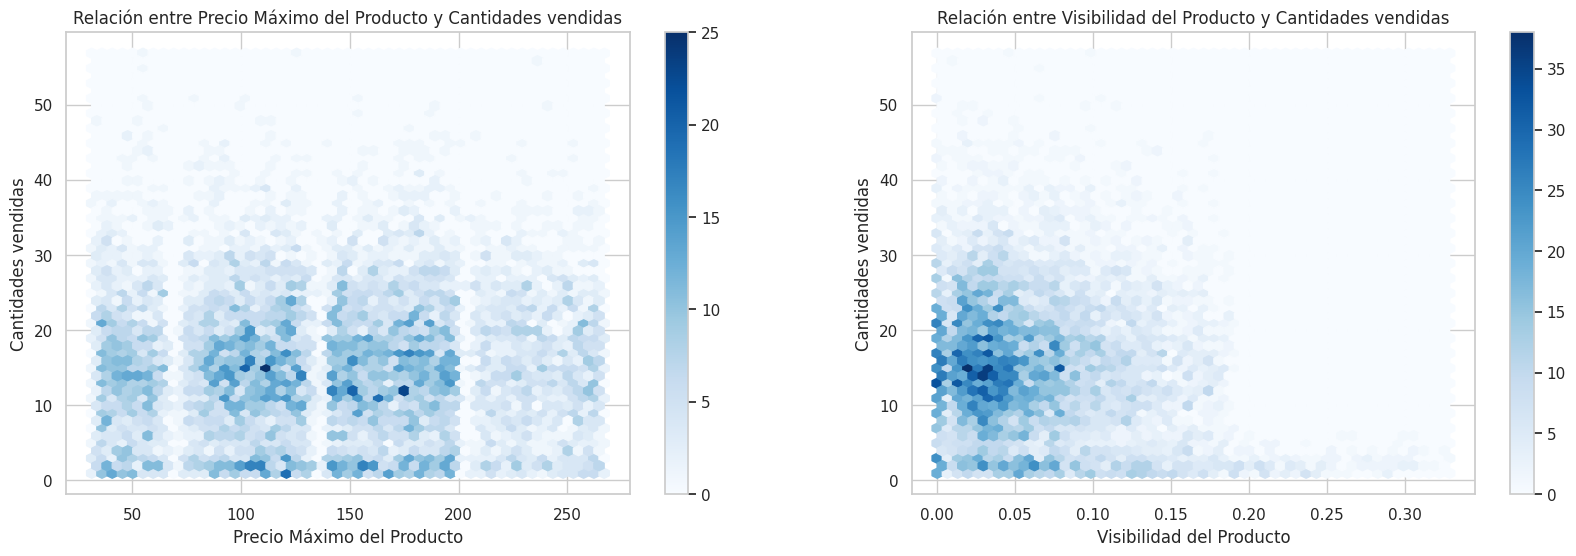

In [56]:
# @title Ventas (en cantidad), según Peso, y Visibilidad del producto
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.hexbin(df_filtered['Item_MRP'], df_filtered['Cantidades_vendidas'], gridsize=50, cmap='Blues')
plt.colorbar()
plt.title('Relación entre Precio Máximo del Producto y Cantidades vendidas')
plt.xlabel('Precio Máximo del Producto')
plt.ylabel('Cantidades vendidas')

plt.subplot(1, 2, 2)
plt.hexbin(df_filtered['Item_Visibility'], df_filtered['Cantidades_vendidas'], gridsize=50, cmap='Blues')
plt.colorbar()
plt.title('Relación entre Visibilidad del Producto y Cantidades vendidas')
plt.xlabel('Visibilidad del Producto')
plt.ylabel('Cantidades vendidas')

plt.show()


Hay una mayor concentración de ventas del producto cuando el MRP toma balores entre 100 y 200. A partir de un precio maximo de 250 las ventas disminuyen, lo que sugiere que los productos con precios más bajos tienden a venderse en mayores cantidades.
A medida que el precio máximo del producto aumenta, la cantidad de productos vendidos disminuye, lo que podría indicar una relación inversa entre el precio y las ventas.

Por tanto una estrategia de precios bajos sería ideal en el caso se desee aumentar las ventas.

Sobre la visibilidad, los puntos están más concentrados alrededor de valores más bajos de visibilidad, lo que indica que los productos con menor visibilidad tienden a tener mayores ventas. Esto podría sugerir que los productos que son menos visibles, posiblemente debido a su familiaridad o popularidad, no necesitan tanta visibilidad para venderse bien.

Considerando ello, se podria crear paquetes de productos que combinen artículos de alto precio con otros de menor precio para equilibrar la percepción de valor y aumentar el volumen de ventas.

In [57]:
sp_df[sp_df['Item_MRP'] > 100]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Cantidades_vendidas
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,14.951963
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,14.809346
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,4.021967
7,FDP10,19.000,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636,37.330006
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,Small,Tier 2,Supermarket Type1,4710.5350,25.079863
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8515,FDH24,20.700,Low Fat,0.021518,Baking Goods,157.5288,OUT018,2009,Medium,Tier 3,Supermarket Type2,1571.2880,9.974608
8517,FDF53,20.750,Regular,0.083607,Frozen Foods,178.8318,OUT046,1997,Small,Tier 1,Supermarket Type1,3608.6360,20.178939
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834,12.951520
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Small,Tier 2,Supermarket Type1,549.2850,5.078589


Interpretación:
* Para los productos con precio menor a 100 USD la visibilidad de los items no es un factor determinante. Esto puede descartar cualquier publicidad que se realice a determinado producto ya que su precio en el mercado no se va a modificar conforme aumente su visibilidad.

## Visualizaciones de Analisis explicativo de Datos

In [58]:
Cantidades_vendidas_por_type = sp_df.groupby(['Item_Type'])['Cantidades_vendidas'].sum()
top_16_type = Cantidades_vendidas_por_type.sort_values(ascending=False).head(16)
top_16_type

Item_Type
Fruits and Vegetables    19331.405072
Snack Foods              18718.673869
Household                13836.714613
Frozen Foods             12936.582569
Canned                   10338.636977
Dairy                    10121.445515
Baking Goods              9943.687764
Health and Hygiene        8057.552691
Soft Drinks               6861.378368
Meat                      6553.540510
Breads                    3971.697765
Hard Drinks               3321.842317
Others                    2478.741999
Starchy Foods             2381.904690
Breakfast                 1572.019650
Seafood                   1047.291893
Name: Cantidades_vendidas, dtype: float64

<ipython-input-59-2cd45eb46517>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




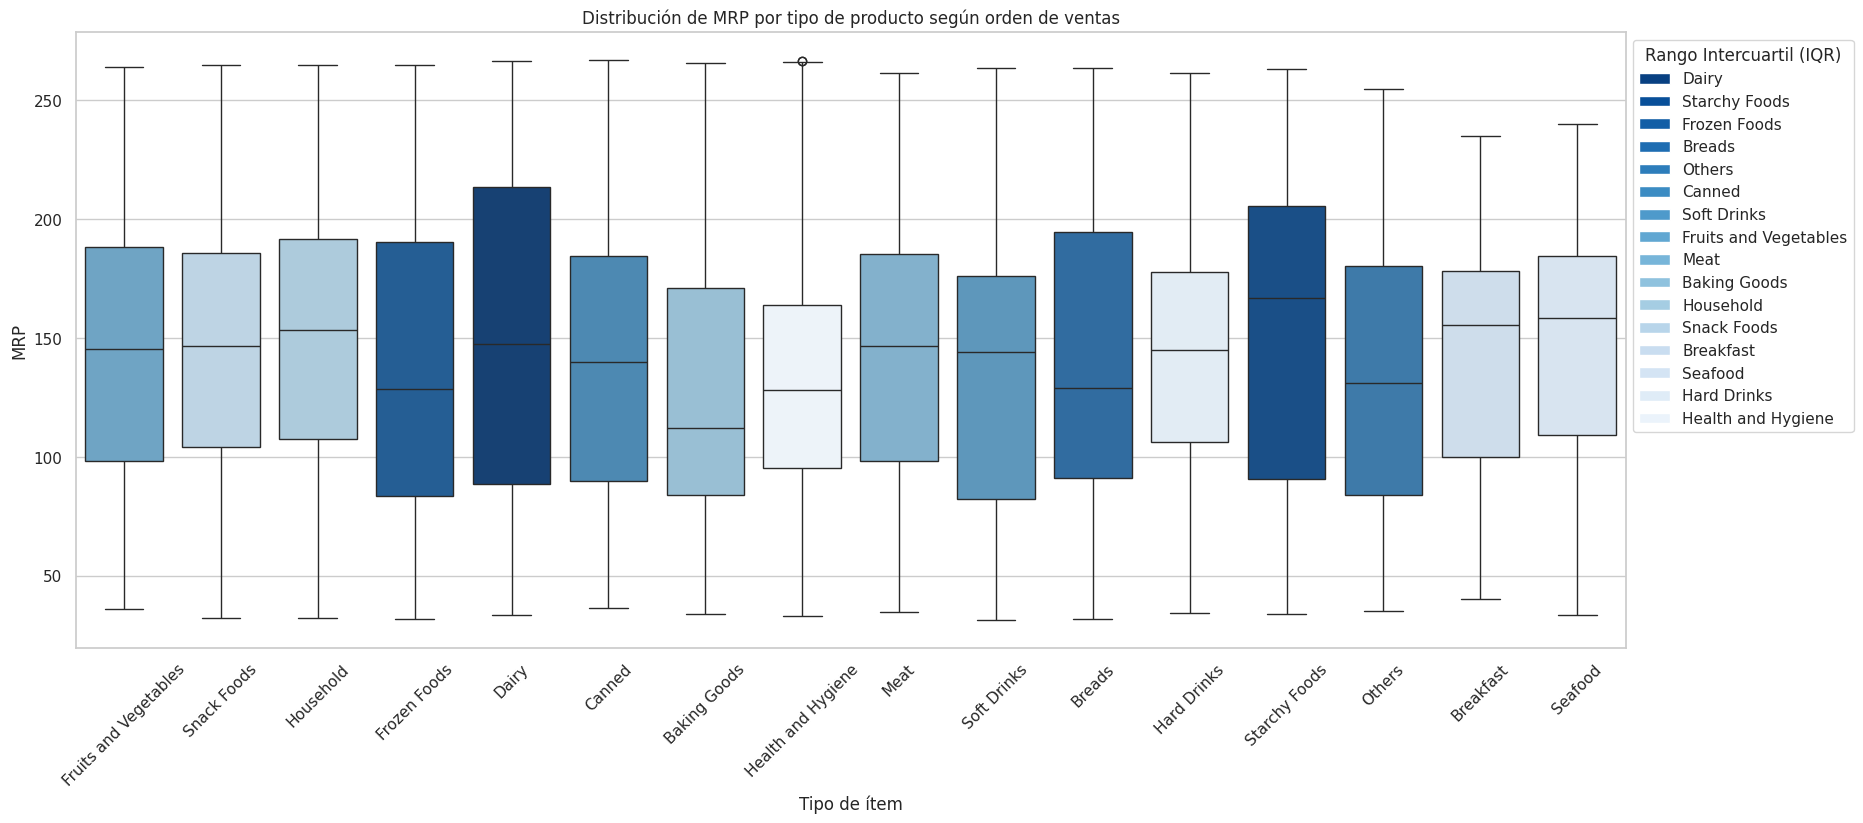

In [59]:
# @title Rango de MRP por categoría, ordenado por ventas descendentes
top_16_item_types = top_16_type.index.get_level_values('Item_Type')
filtered_df = sp_df.loc[sp_df['Item_Type'].isin(top_16_item_types)]

sales_values = filtered_df.groupby('Item_Type')['Item_Outlet_Sales'].sum()
sorted_item_types_by_sales = sales_values.sort_values(ascending=False).index

iqr_values = filtered_df.groupby('Item_Type')['Item_MRP'].apply(lambda x: x.quantile(0.75) - x.quantile(0.25))

palette = sns.color_palette("Blues", n_colors=16)[::-1]

sorted_iqr = iqr_values.sort_values(ascending=False)
color_mapping = {item_type: palette[i] for i, item_type in enumerate(sorted_iqr.index)}

plt.figure(figsize=(20, 8))
sns.boxplot(data=filtered_df, x='Item_Type', y='Item_MRP', order=sorted_item_types_by_sales, palette=color_mapping)
plt.title('Distribución de MRP por tipo de producto según orden de ventas')
plt.xlabel('Tipo de ítem')
plt.ylabel('MRP')
plt.xticks(rotation=45)

legend_elements = [Patch(facecolor=color_mapping[item_type], label=item_type) for item_type in sorted_iqr.index]
plt.legend(handles=legend_elements, title='Rango Intercuartil (IQR)', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

iNTERPRETACION:

La mayor parte de los productos tiene un MRP entre 100 y 200, siendo las categorías más vendidas: Frutas y Vegetales, Snacks y Artículos para el hogar. Las dos categorias de productos menos vendidos, productos relacionados con el Desayuno y Mariscos, tienen menos variabilidad de precios.

Esta información sería muy interesante para poder aplicar una estrategia de precios, junto con promociones o descuentos por el area de marketing, ya que estos productos con un rango menor y menor ventas, podrian estar perdiendo clientes potenciales.

In [60]:
sp_df_precio = sp_df[(sp_df['Item_MRP'] >= 80) & (sp_df['Item_MRP'] <= 100)]
sp_df_precio

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Cantidades_vendidas
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,Small,Tier 2,Supermarket Type1,1076.5986,11.102091
31,NCS17,18.600,Low Fat,0.080829,Health and Hygiene,96.4436,OUT018,2009,Medium,Tier 3,Supermarket Type2,2741.7644,28.428682
33,FDO23,17.850,Low Fat,0.000000,Breads,93.1436,OUT045,2002,Small,Tier 2,Supermarket Type1,2174.5028,23.345703
39,FDB34,15.250,Low Fat,0.026481,Snack Foods,87.6198,OUT027,1985,Medium,Tier 3,Supermarket Type3,2180.4950,24.885871
61,FDV27,7.970,Regular,0.040071,Meat,87.3514,OUT045,2002,Small,Tier 2,Supermarket Type1,1062.6168,12.164851
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8476,NCO41,12.500,Low Fat,0.018887,Health and Hygiene,98.8384,OUT045,2002,Small,Tier 2,Supermarket Type1,1280.9992,12.960542
8479,FDL10,8.395,Low Fat,0.039554,Snack Foods,99.1042,OUT049,1999,Medium,Tier 1,Supermarket Type1,2579.3092,26.026235
8489,FDV13,17.350,Regular,0.027723,Canned,89.6856,OUT018,2009,Medium,Tier 3,Supermarket Type2,2109.2544,23.518317
8513,FDH31,12.000,Regular,0.020407,Meat,99.9042,OUT035,2004,Small,Tier 2,Supermarket Type1,595.2252,5.957960


In [61]:
sp_df['Outlet_Establishment_Year'] = sp_df['Outlet_Establishment_Year'].astype(str).apply(lambda x: x.split('.')[0])

In [62]:
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   object 
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  Cantidades_vendidas        8523 non-null   float64
dtypes: float64(5), object(8)
memory usage: 865.7+ KB

In [63]:
ventas_por_ano_tipo = sp_df.groupby(['Outlet_Establishment_Year', 'Outlet_Type'])['Cantidades_vendidas'].sum().reset_index()
ventas_por_ano = ventas_por_ano_tipo.groupby('Outlet_Establishment_Year')['Cantidades_vendidas'].sum().reset_index()

ventas_por_ano

,Outlet_Establishment_Year,Cantidades_vendidas
0,1985,26170.175536
1,1987,14913.254377
2,1997,15057.629973
3,1998,1322.692377
4,1999,15466.172404
5,2002,14475.949402
6,2004,15785.754166
7,2007,15427.104933
8,2009,12854.383093


In [64]:
ventas_por_ano_tipo2 = sp_df.groupby(['Outlet_Establishment_Year', 'Outlet_Type'])['Item_Outlet_Sales'].sum().reset_index()
ventas_por_ano2 = ventas_por_ano_tipo2.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].sum().reset_index()
ventas_por_ano2

,Outlet_Establishment_Year,Item_Outlet_Sales
0,1985,3.633620e+06
1,1987,2.142664e+06
2,1997,2.118395e+06
3,1998,1.883402e+05
4,1999,2.183970e+06
5,2002,2.036725e+06
6,2004,2.268123e+06
7,2007,2.167465e+06
8,2009,1.851823e+06


In [65]:
df_ventas = pd.DataFrame()
df_ventas['Outlet_Establishment_Year'] = ventas_por_ano2['Outlet_Establishment_Year']
df_ventas['Cantidades_vendidas'] = ventas_por_ano['Cantidades_vendidas']
df_ventas['Item_Outlet_Sales'] = ventas_por_ano2['Item_Outlet_Sales']
df_ventas

,Outlet_Establishment_Year,Cantidades_vendidas,Item_Outlet_Sales
0,1985,26170.175536,3.633620e+06
1,1987,14913.254377,2.142664e+06
2,1997,15057.629973,2.118395e+06
3,1998,1322.692377,1.883402e+05
4,1999,15466.172404,2.183970e+06
5,2002,14475.949402,2.036725e+06
6,2004,15785.754166,2.268123e+06
7,2007,15427.104933,2.167465e+06
8,2009,12854.383093,1.851823e+06


In [66]:
cantidad_por_ano = sp_df.groupby(['Outlet_Establishment_Year'])['Outlet_Identifier'].nunique().reset_index()
cantidad_por_ano_df = pd.DataFrame(cantidad_por_ano)
cantidad_por_ano_df

,Outlet_Establishment_Year,Outlet_Identifier
0,1985,2
1,1987,1
2,1997,1
3,1998,1
4,1999,1
5,2002,1
6,2004,1
7,2007,1
8,2009,1


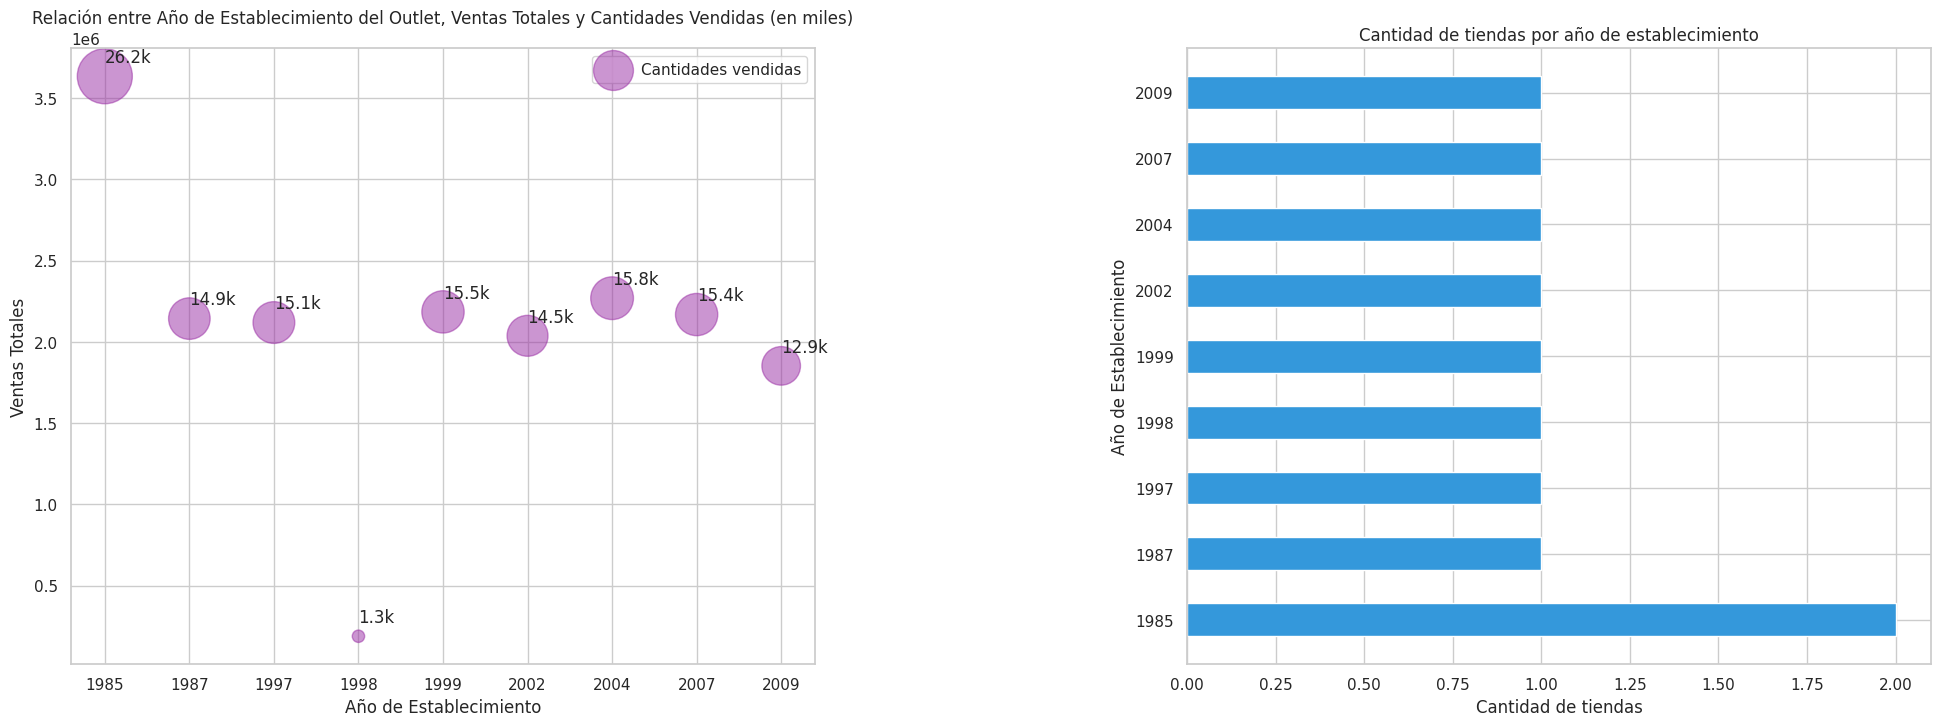

In [67]:
# @title Ventas (en cantidad y u.m.), según año de establecimiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

año_establecimiento = df_ventas['Outlet_Establishment_Year']
cantidades_vendidas = df_ventas['Cantidades_vendidas']
ventas_totales = df_ventas['Item_Outlet_Sales']
tamaño_burbujas = cantidades_vendidas * 0.06


scatter = ax1.scatter(año_establecimiento, ventas_totales, s=tamaño_burbujas, alpha=0.5, color='#992ca4', label='Cantidades vendidas')

for i, txt in enumerate(cantidades_vendidas):
    txt_display = round(txt / 1000, 1)
    ax1.annotate(f'{txt_display}k', (año_establecimiento[i], ventas_totales[i]), textcoords="offset points", xytext=(0,10), ha='left')

ax1.set_xlabel('Año de Establecimiento')
ax1.set_ylabel('Ventas Totales')
ax1.set_title('Relación entre Año de Establecimiento del Outlet, Ventas Totales y Cantidades Vendidas (en miles)')
ax1.legend()

ax2.barh(cantidad_por_ano_df['Outlet_Establishment_Year'], cantidad_por_ano_df['Outlet_Identifier'], color='#3498db', height=0.5)

ax2.set_xlabel('Cantidad de tiendas')
ax2.set_ylabel('Año de Establecimiento')
ax2.set_title('Cantidad de tiendas por año de establecimiento')

plt.subplots_adjust(wspace=0.5)

plt.show()

Existe una tienda por año, excepto en 1985, cuando se adjudicaron/crearon 2 tiendas. Las cantidades vendidas por cada una de ellas es bastante similar, excepto por la tienda adjudicada/creada en el año 2009 que se encuentra por debajo del resto, y muy por debajo la tienda creada en 1998, con cantidades y volumenes de venta 10 veces menores al resto.



In [68]:
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   object 
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  Cantidades_vendidas        8523 non-null   float64
dtypes: float64(5), object(8)
memory usage: 865.7+ KB

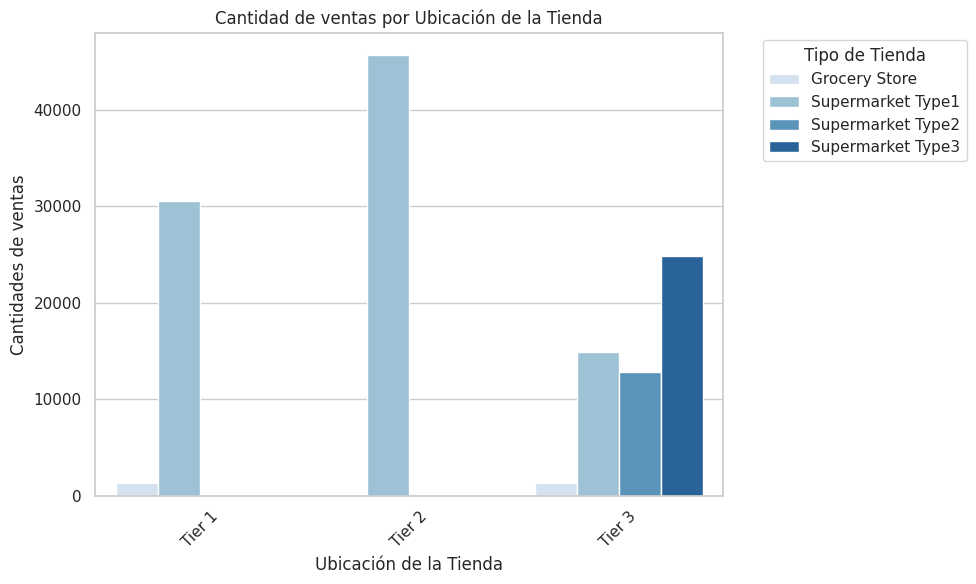

In [69]:
# @title Cantidad de ventas por ubicación de tienda y tipo de tienda
df_ubicacion = sp_df.groupby(['Outlet_Location_Type', 'Outlet_Type'])['Cantidades_vendidas'].sum().reset_index()

plt.figure(figsize=(10, 6))

palette = sns.color_palette("Blues", len(df_ubicacion['Outlet_Type'].unique()))

sns.barplot(data=df_ubicacion, x='Outlet_Location_Type', y='Cantidades_vendidas', hue='Outlet_Type', dodge=True, palette=palette)

plt.title('Cantidad de ventas por Ubicación de la Tienda')
plt.xlabel('Ubicación de la Tienda')
plt.ylabel('Cantidades de ventas')

plt.xticks(rotation=45)

plt.legend(title='Tipo de Tienda', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Interpretación:

Tanto las tiendas ubicadas en el Tier 1 como el Tier 2 generan mayor cantidad de ventas, esto significa que estos lugares son una posición estratégica para crear nuevas tiendas. Sin embargo, en el  grafico analizaremos que productos son vendidos en cada una de las tiendas.

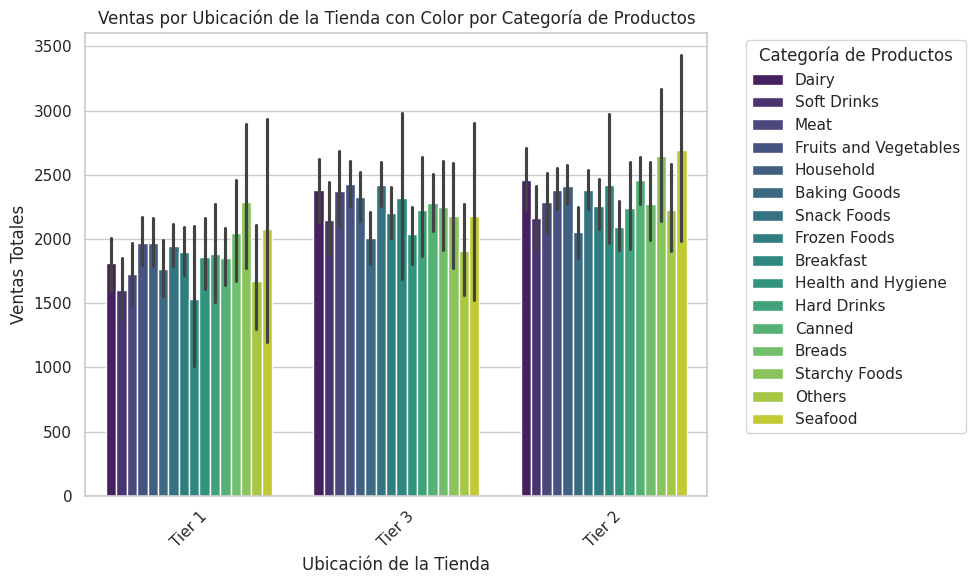

In [70]:
plt.figure(figsize=(10, 6))
sns.barplot(data=sp_df, x='Outlet_Location_Type', y='Item_Outlet_Sales', hue='Item_Type', palette='viridis')
plt.title('Ventas por Ubicación de la Tienda con Color por Categoría de Productos')
plt.xlabel('Ubicación de la Tienda')
plt.ylabel('Ventas Totales')
plt.xticks(rotation=45)
plt.legend(title='Categoría de Productos', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



Interpretación:

Observamos que tanto Tier 2 como Tier 3 tienen como productos principal los al tipo Seafood, y en un segundo lugar destaca Starchy Foods y Breakfast respectivamente. Este patron de tener a Seafood como uno de los productos mas vendidos tambien se repite en Tier 1, aunque alli en cambio se destaca los productos tipos Bread. Esta combinación de preferencias de productos por ubicación es ideal para identificar patrones de consumo y de comportamiento del consumidor.

# Configuracion X , Y

In [71]:
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   object 
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  Cantidades_vendidas        8523 non-null   float64
dtypes: float64(5), object(8)
memory usage: 865.7+ KB

Nuestra target sera Item_Outlet_Sales, para eso vamos a verificar sus valores.

In [72]:
sp_df['Item_Outlet_Sales'].unique()

array([3735.138 ,  443.4228, 2097.27  , ..., 7182.6504, 3608.636 ,
       2778.3834])

In [73]:
sp_df['Item_Outlet_Sales'].isna().sum()

0

In [74]:
sp_df['Item_Outlet_Sales'].describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

Todo esta en orden con nuestra target, procedemos a definix X y y

In [75]:
X = sp_df.drop(['Item_Outlet_Sales'], axis=1)
y = sp_df['Item_Outlet_Sales']

In [76]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   object 
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Cantidades_vendidas        8523 non-null   float64
dtypes: float64(4), object(8)
memory usage: 799.2+ KB


In [77]:
X['Item_Identifier'].unique()

array(['FDA15', 'DRC01', 'FDN15', ..., 'NCF55', 'NCW30', 'NCW05'],
      dtype=object)

In [78]:
X['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [79]:
X['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

In [80]:
X['Outlet_Identifier'].unique()

array(['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045',
       'OUT017', 'OUT046', 'OUT035', 'OUT019'], dtype=object)

In [81]:
X['Outlet_Establishment_Year'].unique()

array(['1999', '2009', '1998', '1987', '1985', '2002', '2007', '1997',
       '2004'], dtype=object)

In [82]:
X['Outlet_Size'].unique()

array(['Medium', 'Small', 'High'], dtype=object)

In [83]:
X['Outlet_Location_Type'].unique()

array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object)

In [84]:
X['Outlet_Type'].unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

Tenemos:

* 7 caracteristicas categoricas, que segun la descripcion establecida tomaremos como nominales:
   * Item_Identifier, Item_Fat_Content, Item_Type, Outlet_Identifier, Outlet_Size,  Outlet_Location_Type, Outlet_Type

En el caso de Outlet_Establishment_Year  es un object porque representa el año, y para un analisis seria mas interesante la antiguedad. Por ello se procedera a modificar la columna:

In [85]:
X['Outlet_Establishment_Year'] = pd.to_numeric(X['Outlet_Establishment_Year'])
X['Antiguedad'] = 2024 - X['Outlet_Establishment_Year']
X = X.drop(columns=['Outlet_Establishment_Year'])

In [86]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_Identifier       8523 non-null   object 
 1   Item_Weight           8523 non-null   float64
 2   Item_Fat_Content      8523 non-null   object 
 3   Item_Visibility       8523 non-null   float64
 4   Item_Type             8523 non-null   object 
 5   Item_MRP              8523 non-null   float64
 6   Outlet_Identifier     8523 non-null   object 
 7   Outlet_Size           8523 non-null   object 
 8   Outlet_Location_Type  8523 non-null   object 
 9   Outlet_Type           8523 non-null   object 
 10  Cantidades_vendidas   8523 non-null   float64
 11  Antiguedad            8523 non-null   int64  
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Por tanto ahora nuestro dataframe solo tiene variables numericas y categoricas nominales, procederemos a transformar.

# Preprocesamiento

Vamos a escalar los datos de nuestra X

In [87]:
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

one_hot_encoder = OneHotEncoder()
standard_scaler = StandardScaler()

imputer_num = SimpleImputer(strategy="mean")
imputer_cat = SimpleImputer(strategy="most_frequent")

Creo mis pipelines

In [88]:
col_transformer = make_column_transformer((make_pipeline(imputer_num,standard_scaler), num_selector),
                                          (make_pipeline(imputer_cat,one_hot_encoder), cat_selector),
                        remainder = 'passthrough')

col_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7910e0988e50>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7910e09447c0>)])

In [89]:
col_transformer.fit(X)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7910e0988e50>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7910e09447c0>)])

In [90]:
aux=col_transformer.transform(X)
aux_array = aux.toarray()
X_procesado=pd.DataFrame(aux_array,columns=col_transformer.get_feature_names_out())
X_procesado.info()
X_procesado

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Columns: 1602 entries, pipeline-1__Item_Weight to pipeline-2__Outlet_Type_Supermarket Type3
dtypes: float64(1602)
memory usage: 104.2 MB


,pipeline-1__Item_Weight,pipeline-1__Item_Visibility,pipeline-1__Item_MRP,pipeline-1__Cantidades_vendidas,pipeline-1__Antiguedad,pipeline-2__Item_Identifier_DRA12,pipeline-2__Item_Identifier_DRA24,pipeline-2__Item_Identifier_DRA59,pipeline-2__Item_Identifier_DRB01,pipeline-2__Item_Identifier_DRB13,...,pipeline-2__Outlet_Size_High,pipeline-2__Outlet_Size_Medium,pipeline-2__Outlet_Size_Small,pipeline-2__Outlet_Location_Type_Tier 1,pipeline-2__Outlet_Location_Type_Tier 2,pipeline-2__Outlet_Location_Type_Tier 3,pipeline-2__Outlet_Type_Grocery Store,pipeline-2__Outlet_Type_Supermarket Type1,pipeline-2__Outlet_Type_Supermarket Type2,pipeline-2__Outlet_Type_Supermarket Type3
0,-0.769512,-0.970732,1.747454,-0.051536,-0.139541,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.497170,-0.908111,-1.489023,-0.678759,-1.334103,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.995811,-0.956917,0.010040,-0.067051,-0.139541,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.361793,-1.281758,0.660050,-1.240598,-0.020085,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,-0.849167,-1.281758,-1.399220,0.330956,1.293934,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,-1.293727,-0.181193,1.180783,-0.269162,1.293934,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
8519,-0.967573,-0.371154,-0.527301,-1.125649,-0.497909,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8520,-0.489644,-0.599784,-0.897208,-0.153309,-0.736822,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8521,-1.219454,1.532880,-0.607977,0.268665,-1.334103,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


En este caso por la cantidad de informacion que contiene (1605 columnas), se uso toarray( )

# Aplicando el modelo de regresion Random Forest Regression

Divido en test de entrenamiento y prueba

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_procesado, y, test_size=0.3, random_state=42)

Defino los parametros del modelo

In [92]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

In [93]:
random_forest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Calculo mi y predicho

In [94]:
y_pred = random_forest.predict(X_test)

# Reviso las metricas de la primera version de mi modelo

In [95]:
print('Accuracy test:', random_forest.score(X_test, y_test))
print('Accuracy train:', random_forest.score(X_train, y_train))

Accuracy test: 0.9986084974848503
Accuracy train: 0.9997730439873177


El modelo tiene un muy buen grado de ajuste con mi data  y casi nula diferencia entre los mismos, por tanto tenemos revisar las otras metricas

In [96]:
mse = mean_squared_error(y_test, y_pred)
print("Error Cuadrático Medio (MSE):", mse)

r2 = r2_score(y_test, y_pred)
print("Coeficiente de Determinación (R^2):", r2)

mae = mean_absolute_error(y_test, y_pred)
print("Error Absoluto Medio (MAE):", mae)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Raíz del Error Cuadrático Medio (RMSE):", rmse)

Error Cuadrático Medio (MSE): 3897.5895382416684
Coeficiente de Determinación (R^2): 0.9986084974848503
Error Absoluto Medio (MAE): 22.938301996089113
Raíz del Error Cuadrático Medio (RMSE): 62.430677861462215


Interpretación:

* El modelo de Random Forest tiene un rendimiento muy bueno en este conjunto de datos. Las métricas de evaluación, como el coeficiente de determinación (R^2) cercano a 1 y el bajo error cuadrático medio (MSE), indican que el modelo es capaz de predecir con precisión las ventas de los productos.

* El coeficiente de determinación (R^2) de 0.9987 indica que el 99.87% de la variabilidad en las ventas de los productos es explicada por el modelo. Esto sugiere que el modelo captura efectivamente la relación entre las características de los productos y sus ventas.

* El error absoluto medio (MAE) de aproximadamente 22.79 unidades indica que, en promedio, las predicciones del modelo están a una distancia de aproximadamente 22.79 unidades del valor real de las ventas de los productos. Este error parece ser razonablemente bajo, considerando la naturaleza de los datos.

* El valor de la raíz del error cuadrático medio (RMSE) de aproximadamente 61.39 unidades indica que las predicciones del modelo están bastante cerca de los valores reales de las ventas de los productos, con una dispersión moderada alrededor de las predicciones.


# Uso de grid search para mejorar hiperparametros

In [97]:
n_estimators_values = [100, 200, 300, 400, 500]

In [98]:
random_forest1 = RandomForestRegressor(random_state=42)

In [99]:
grid_search = GridSearchCV(estimator=random_forest1, param_grid={'n_estimators': n_estimators_values}, cv=3, scoring='neg_mean_squared_error')

In [100]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_mean_squared_error')

In [101]:
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'n_estimators': 500}


Usemos el mejor parametro para nuevamente ejecutar nuestro modelo

In [102]:
best_model = grid_search.best_estimator_

In [103]:
y_pred_b = best_model.predict(X_test)

# Reviso las metricas de la segunda version de mi modelo

In [104]:
print('Accuracy train modelo mejorado:', best_model.score(X_train, y_train))
print('Accuracy test modelo mejorado:', best_model.score(X_test, y_test))

Accuracy train modelo mejorado: 0.9998141345722811
Accuracy test modelo mejorado: 0.9987109917823102


In [105]:
print('Accuracy test primer modelo:', random_forest.score(X_test, y_test))
print('Accuracy train primer modelo:', random_forest.score(X_train, y_train))

Accuracy test primer modelo: 0.9986084974848503
Accuracy train primer modelo: 0.9997730439873177


Ambos modelos muestran una excelente precisión tanto en el conjunto de entrenamiento como en el conjunto de prueba. Sin embargo, el modelo mejorado parece tener un ligero incremento en la precisión en comparación con el primer modelo en ambos conjuntos.

In [106]:
mseb = mean_squared_error(y_test, y_pred_b)
print("Error Cuadrático Medio (MSE):", mseb)

r2b = r2_score(y_test, y_pred_b)
print("Coeficiente de Determinación (R^2):", r2b)

maeb = mean_absolute_error(y_test, y_pred_b)
print("Error Absoluto Medio (MAE):", maeb)

rmseb = mean_squared_error(y_test, y_pred_b, squared=False)
print("Raíz del Error Cuadrático Medio (RMSE):", rmseb)

Error Cuadrático Medio (MSE): 3610.503674465036
Coeficiente de Determinación (R^2): 0.9987109917823102
Error Absoluto Medio (MAE): 21.80983374845545
Raíz del Error Cuadrático Medio (RMSE): 60.08746686676878


Revisando los errores, el mejor modelo tiene un buen ajuste global según el coeficiente de determinación (R^2), pero muestra un error medio relativamente alto (MSE) y errores de predicción moderadamente grandes (RMSE y MAE). Es posible que se necesiten ajustes adicionales para mejorar aún más la precisión del modelo.

# Revision asociacion de cada caracteristica - prediccion de ventas

Generamos una lista de las variables mas importantes para predecir las ventas de productos

In [108]:
importances = random_forest.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_procesado.columns, 'Importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                Feature  Importance
3       pipeline-1__Cantidades_vendidas    0.610033
2                  pipeline-1__Item_MRP    0.388533
1           pipeline-1__Item_Visibility    0.000355
0               pipeline-1__Item_Weight    0.000269
1315  pipeline-2__Item_Identifier_NCE42    0.000076
...                                 ...         ...
633   pipeline-2__Item_Identifier_FDM16    0.000000
127   pipeline-2__Item_Identifier_DRM11    0.000000
582   pipeline-2__Item_Identifier_FDK57    0.000000
474   pipeline-2__Item_Identifier_FDI02    0.000000
884   pipeline-2__Item_Identifier_FDS14    0.000000

[1602 rows x 2 columns]


In [109]:
sp_df['Item_MRP'].unique()

array([249.8092,  48.2692, 141.618 , ...,  57.5904, 214.5218,  75.467 ])

Segun se observa, que las cantidades vendidas es la característica más importante para predecir las ventas de productos, seguida por el precio minorista maximo (en lista) del producto.

Esto indica que el precio de los productos juega un papel importante en las ventas, siendo una buena decisión estratégica ajustar los precios de los productos.

# Mejora del modelo Random Forest

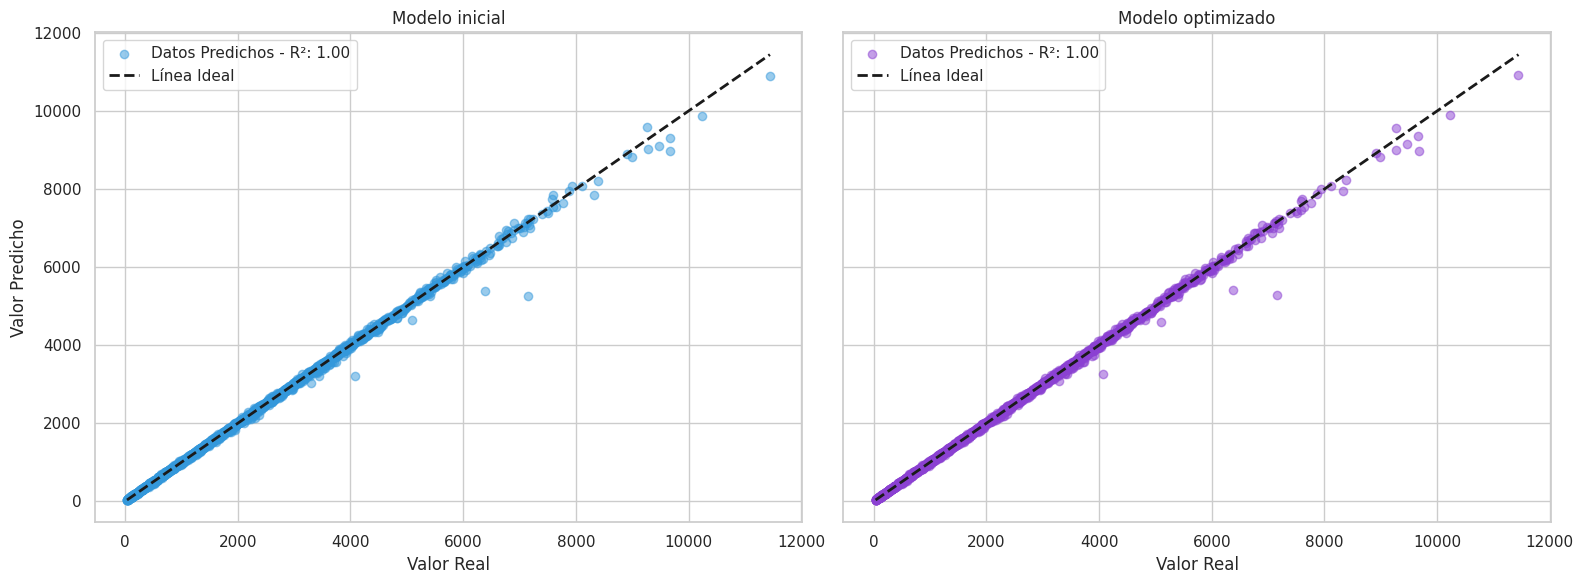

In [131]:
# @title Comparación entre valores Reales y valores Predichos por cada Modelo

accuracy1 = r2_score(y_test, y_pred)
accuracy2 = r2_score(y_test, y_pred_b)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)

axes[0].scatter(y_test, y_pred, color='#3498db', alpha=0.5, label=f'Datos Predichos - R²: {accuracy1:.2f}')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Línea Ideal')
axes[0].set_title('Modelo inicial')
axes[0].set_xlabel('Valor Real')
axes[0].set_ylabel('Valor Predicho')
axes[0].legend()

axes[1].scatter(y_test, y_pred_b, color='#8b41d2', alpha=0.5, label=f'Datos Predichos - R²: {accuracy2:.2f}')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Línea Ideal')
axes[1].set_title('Modelo optimizado')
axes[1].set_xlabel('Valor Real')
axes[1].legend()

plt.tight_layout()
plt.show()

La mejora en el coeficiente de determinación (R²), aunque ligera, de 0.99861 a 0.99871, refuerza la evidencia de que el modelo ajusta mejor los datos observados. Este incremento, aunque pequeño, es consistente con las demás mejoras y sugiere una afinidad más fuerte entre los valores predichos y los valores reales, reflejando un ajuste marginalmente superior al modelo inicial.



En el análisis de regresión, nuestro modelo muestra una fuerte capacidad para predecir correctamente los valores en un amplio rango. Sin embargo, se observan algunas discrepancias, particularmente en los valores más altos donde el modelo tiende a subestimar los resultados. Este comportamiento podría requerir una investigación adicional para mejorar la precisión del modelo, como ajustar hiperparámetros o explorar diferentes técnicas de modelado para mejor manejo de los valores extremos.

In [126]:
# @title Métricas por cada modelo
data = {
    'Modelo': ['Modelo 1', 'Modelo 2'],
    'Accuracy Test': [0.99977, 0.99981],
    'Accuracy Train': [0.99861, 0.99871],
    'MSE': [3897.59, 3610.50],
    'MAE': [22.94, 21.81],
    'RMSE': [62.43, 60.09],
    'R²': [0.99861, 0.99871]
}

results_df = pd.DataFrame(data)

print(results_df)

     Modelo  Accuracy Test  Accuracy Train      MSE    MAE   RMSE       R²
0  Modelo 1        0.99977         0.99861  3897.59  22.94  62.43  0.99861
1  Modelo 2        0.99981         0.99871  3610.50  21.81  60.09  0.99871


El análisis de las métricas de rendimiento para el modelo inicial de Random Forest y su versión optimizada mediante Grid Search demuestra mejoras significativas en varios aspectos clave. La precisión del modelo en los conjuntos de entrenamiento y prueba incrementó ligeramente después de la optimización, pasando de 0.99977 a 0.99981 y de 0.99861 a 0.99871, respectivamente, lo que indica una mejora en la capacidad del modelo para predecir los datos sin ser visto previamente.

En términos de errores, se observó una reducción notable en todas las métricas principales: el Error Cuadrático Medio (MSE) disminuyó de 3897.59 a 3610.50, el Error Absoluto Medio (MAE) se redujo de 22.94 a 21.81, y la Raíz del Error Cuadrático Medio (RMSE) bajó de 62.43 a 60.09. Estas disminuciones indican que el modelo optimizado es más preciso en sus predicciones y muestra una menor variabilidad de errores, lo cual es esencial para la confiabilidad en las aplicaciones prácticas.




# Conclusiones y Recomendaciones

* El público objetivo de la empresa son clientes habituales orientados a productos mayormente saludables, y que conocen bien a los productos.
* Los productos bajos en grasa son el 64.7%, sin embargo no predominan en las ventas. Se podria diversificar los productos, aumentado a mas productos regulares, y por otro lado realizar campañas enfocadas a mostrar los beneficios de consumir productos bajos en grasa.
* Aunque los productos de bajo costo dominan las ventas, explorar el potencial de introducir productos con mayor valor añadido puede ayudar a aumentar los márgenes de ganancia. Para ello es ideal considerar un MRP menor a 200 como precio de entrada.
* Se debe aumentar la visibilidad y publicidad de aquellos productos con menores ventas, a fin de poder captar a nuevos clientes.
* Las categorias que representan menores ventas (tales como Breakfast y Seafood), deben ser ofertadas en parquetes de productos que combinen articulos de alta rotacion de ventas.
* Realizar un análisis más profundo de las tiendas inauguradas en 1998 y 2009 para identificar causas de su bajo rendimiento y desarrollar estrategias de recuperación.

